In [2]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from sklearn.metrics import classification_report
import shutil

In [ ]:
# Read dataset
database_directory = "../Dataset/Oral Dose Forms"

# Initialize counters
file_counts = {}
total_files = 0

# Loop through files in the directory
for filename in os.listdir(database_directory):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):  # Add more formats if needed
        total_files += 1
        file_ext = filename.split(".")[-1].lower()  # Extract file extension
        file_counts[file_ext] = file_counts.get(file_ext, 0) + 1  # Count file types

# Print summary
print("**Dataset Summary**")
print(f"Dataset Path: {database_directory}")
print(f"Total Images: {total_files}")

# Print breakdown by file type
for ext, count in file_counts.items():
    print(f"   - {ext.upper()} files: {count}")

# Print sample filenames
sample_files = os.listdir(database_directory)[:5]  # Show first 5 files
print("Sample Filenames:", sample_files)

**Dataset Summary**
Dataset Path: C:/Users/Amni/Downloads/Oral Dose Forms
Total Images: 25988
   - JPG files: 25920
   - JPEG files: 36
   - PNG files: 32
Sample Filenames: ['Abacavir (Ziagen) 300mg Tab [09Sep13]_0.jpg', 'Abacavir (Ziagen) 300mg Tab [09Sep13]_0_aug_1.jpg', 'Abacavir (Ziagen) 300mg Tab [09Sep13]_0_aug_2.jpg', 'Abacavir (Ziagen) 300mg Tab [09Sep13]_0_aug_3.jpg', 'Abacavir (Ziagen) 300mg Tab [09Sep13]_1.jpg']


In [ ]:
import tensorflow as tf
import numpy as np

# Load EfficientNetB0 for feature extraction
efficientnet_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Define the model with a global pooling layer
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation="softmax")  # Adjust output units for your number of classes
])

# Compile the model with Recall as a metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Use SparseCategoricalCrossentropy() for integer labels
    metrics=['accuracy', tf.keras.metrics.Recall()]  # Include Recall
)

# Show model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [5]:
# Define a function to preprocess an image and extract features
def extract_features(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    # Apply L2 normalization to the features
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    return features

In [14]:
# Extract features from all images in the database and cache them
database_features = []
database_filenames = []
for filename in os.listdir(database_directory):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(database_directory, filename)
        features = extract_features(image_path)
        database_features.append(features.flatten())  # Flatten the features
        database_filenames.append(filename)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [15]:
# Save extracted features and filenames
np.save("database_features.npy", np.array(database_features))
np.save("database_filenames.npy", np.array(database_filenames))
print("Features saved successfully!")

Features saved successfully!


In [16]:
# Load previously saved features
database_features = np.load("database_features.npy", allow_pickle=True)
database_filenames = np.load("database_filenames.npy", allow_pickle=True)
print("Features loaded successfully!")


Features loaded successfully!


In [ ]:
class MetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("loss")
        recall = logs.get("recall")
        print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Recall = {recall:.4f}")

# Instantiate the callback
metrics_logger = MetricsLogger()


In [17]:
# Create an AnnoyIndex for approximate nearest neighbor search
num_trees = 200  # Adjust this parameter for better accuracy
feature_dim = len(database_features[0])
annoy_index = AnnoyIndex(feature_dim, 'angular')  # Use cosine similarity

# Add database features to the AnnoyIndex
for i, feature in enumerate(database_features):
    annoy_index.add_item(i, feature)

# Build the index
annoy_index.build(num_trees)

# Load the query image
query_image_path = "C:/Users/Amni/Downloads/Oral Dose Forms/Warfarin (Marevan Bottle) 5mg Tab_0.png"
query_features = extract_features(query_image_path).flatten()  # Flatten the query features

# Ensure query_features has the correct shape
query_features = np.squeeze(query_features)  # Convert (1, 1280) -> (1280,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Similar Image 1: Warfarin (Marevan Bottle) 5mg Tab_0.png | Distance - 0.00
Similar Image 2: Warfarin (Marevan Bottle) 5mg Tab_0_aug_2.png | Distance - 0.06
Similar Image 3: Warfarin (Marevan Bottle) 1mg Tab_0.png | Distance - 0.37
Similar Image 4: Warfarin (Marevan Bottle) 1mg Tab_0_aug_3.png | Distance - 0.37
Similar Image 5: Warfarin (Marevan Bottle) 3mg Tab_0.png | Distance - 0.41


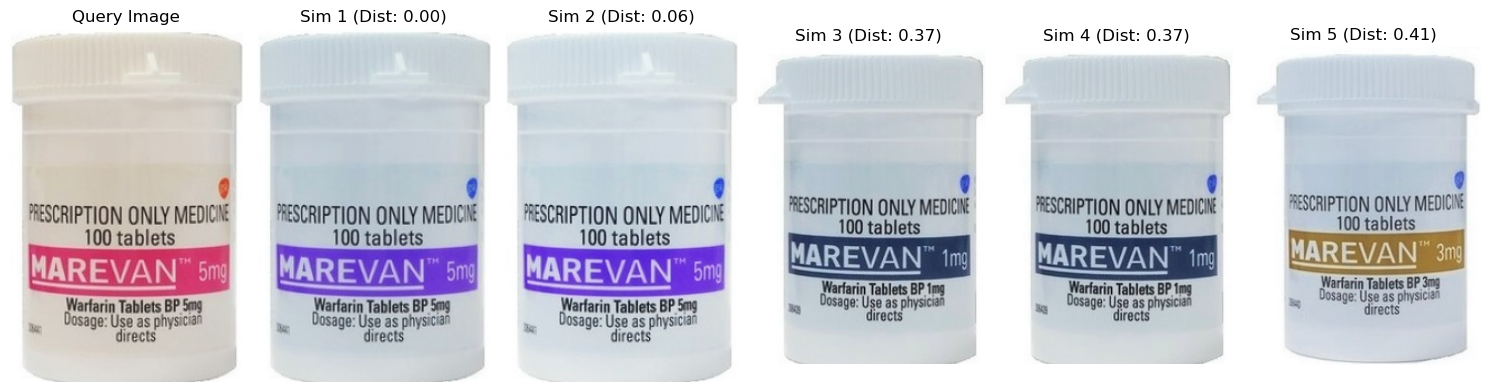

In [18]:
# Define the number of similar images to retrieve
top_n = 5

# Find the top N similar images
similar_indices = annoy_index.get_nns_by_vector(query_features, top_n)

# Create a figure to display images
fig, axes = plt.subplots(1, top_n + 1, figsize=(15, 5))


# Display the top N most similar images and their distances
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
for i, index in enumerate(similar_indices):
    similar_image_filename = database_filenames[index]
    similar_image_path = os.path.join(database_directory, similar_image_filename)
    similar_image = cv2.imread(similar_image_path)
    # Calculate the distance manually
    distance = np.linalg.norm(query_features - database_features[index])
    print(f"Similar Image {i + 1}: {similar_image_filename} | Distance - {distance:.2f}")
    cv2.imshow(f"Similar Image {i + 1}", similar_image)
     # Plot the similar image
    axes[i + 1].imshow(similar_image)
    axes[i + 1].set_title(f"Sim {i + 1} (Dist: {distance:.2f})")
    axes[i + 1].axis("off")

# Plot query image
axes[0].imshow(query_image)
axes[0].set_title("Query Image")
axes[0].axis("off")

# Show the plot
plt.tight_layout()
plt.show()

Similar Image 1: Warfarin (Marevan Bottle) 1mg Tab_0.png | Distance - 0.37
Similar Image 2: Warfarin (Marevan Bottle) 3mg Tab_0.png | Distance - 0.41
Similar Image 3: Phenoxybenzamine (Dibenyline Bottle) 10mg Tab_0.jpg | Distance - 0.58
Similar Image 4: Biktarvy Tab (Side Box) (BICTEGRAVIR 50mg + EMTRICITABINE 200mg + TENOFOVIR 25mg) v2 [5February2020]_0.jpg | Distance - 0.62


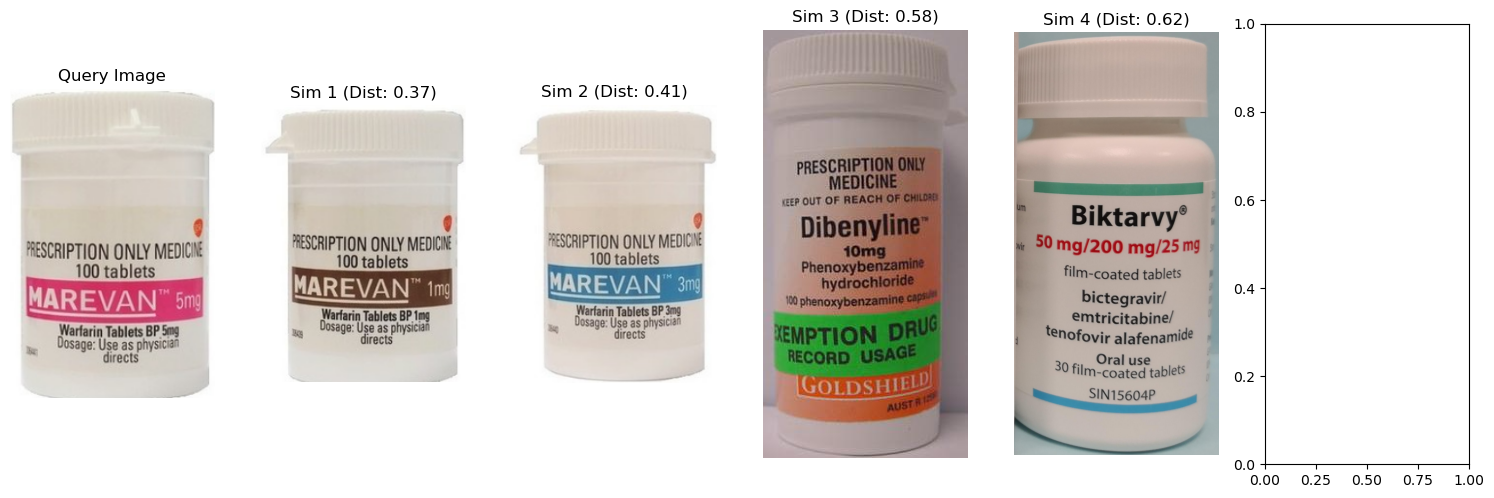

In [19]:
# Define the number of similar images to retrieve
top_n = 15  # Fetch more images to filter augmented ones
final_n = 5  # Number of unique images to display

# Extract query image filename (without path)
query_image_filename = os.path.basename(query_image_path)

# Find the top N similar images
similar_indices = annoy_index.get_nns_by_vector(query_features, top_n)

# Initialize list to store non-augmented and unique medication images
filtered_similar_images = []

for index in similar_indices:
    similar_image_filename = database_filenames[index]
    
    # Skip augmented images
    if "_aug_" in similar_image_filename:
        continue  
    
    # Exclude the query image itself
    if similar_image_filename == query_image_filename:
        continue  

    # Ensure unique medication names (Extract base name)
    med_name = similar_image_filename.split("_")[0]  # Extract base name before numbers
    if med_name not in [img.split("_")[0] for img in filtered_similar_images]:
        filtered_similar_images.append(similar_image_filename)
    
    # Stop once we have the required number of unique images
    if len(filtered_similar_images) >= final_n:
        break  

# Create a figure to display images
fig, axes = plt.subplots(1, final_n + 1, figsize=(15, 5))

# Load and plot query image
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
axes[0].imshow(query_image)
axes[0].set_title("Query Image")
axes[0].axis("off")

# Display the filtered similar images
for i, filename in enumerate(filtered_similar_images):
    similar_image_path = os.path.join(database_directory, filename)
    similar_image = cv2.imread(similar_image_path)
    similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Ensure database_filenames is treated as a list before using .index()
    index_in_database = list(database_filenames).index(filename)

    # Calculate the distance correctly
    distance = np.linalg.norm(query_features - database_features[index_in_database])

    print(f"Similar Image {i + 1}: {filename} | Distance - {distance:.2f}")

    # Plot similar image
    axes[i + 1].imshow(similar_image)
    axes[i + 1].set_title(f"Sim {i + 1} (Dist: {distance:.2f})")
    axes[i + 1].axis("off")

# Show the plot
plt.tight_layout()
plt.show()
